In [ ]:
# Import the library
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
human = pd.read_table('https://raw.githubusercontent.com/yoshikazuuu/data-science/main/human.txt')
human.head()

,sequence,class
0,ATGCCCCAACTAAATACTACCGTATGGCCCACCATAATTACCCCCA...,4
1,ATGAACGAAAATCTGTTCGCTTCATTCATTGCCCCCACAATCCTAG...,4
2,ATGTGTGGCATTTGGGCGCTGTTTGGCAGTGATGATTGCCTTTCTG...,3
3,ATGTGTGGCATTTGGGCGCTGTTTGGCAGTGATGATTGCCTTTCTG...,3
4,ATGCAACAGCATTTTGAATTTGAATACCAGACCAAAGTGGATGGTG...,3


In [ ]:
chimp = pd.read_table('https://raw.githubusercontent.com/yoshikazuuu/data-science/main/chimpanzee.txt')
chimp.head()


,sequence,class
0,ATGCCCCAACTAAATACCGCCGTATGACCCACCATAATTACCCCCA...,4
1,ATGAACGAAAATCTATTCGCTTCATTCGCTGCCCCCACAATCCTAG...,4
2,ATGGCCTCGCGCTGGTGGCGGTGGCGACGCGGCTGCTCCTGGAGGC...,4
3,ATGGCCTCGCGCTGGTGGCGGTGGCGACGCGGCTGCTCCTGGAGGC...,4
4,ATGGGCAGCGCCAGCCCGGGTCTGAGCAGCGTGTCCCCCAGCCACC...,6


In [ ]:
dog = pd.read_table('https://raw.githubusercontent.com/yoshikazuuu/data-science/main/dog.txt')
dog.head()

,sequence,class
0,ATGCCACAGCTAGATACATCCACCTGATTTATTATAATCTTTTCAA...,4
1,ATGAACGAAAATCTATTCGCTTCTTTCGCTGCCCCCTCAATAATAG...,4
2,ATGGAAACACCCTTCTACGGCGATGAGGCGCTGAGCGGCCTGGGCG...,6
3,ATGTGCACTAAAATGGAACAGCCCTTCTACCACGACGACTCATACG...,6
4,ATGAGCCGGCAGCTAAACAGAAGCCAGAACTGCTCCTTCAGTGACG...,0


# Treating DNA Sequence as a "Language" ,otherwise Known as K-Mer Counting

**In bioinformatics, k-mers are substrings of length k contained within a biological sequence. Primarily used within the context of computational genomics and sequence analysis, in which k-mers are composed of nucleotides (i.e. A, T, G, and C), k-mers are capitalized upon to assemble DNA sequences,improve heterologous gene expression, identify species in metagenomic samples, and create attenuated vaccines.**

k-mers are simply length k subsequences. For example, all the possible k-mers of a DNA sequence are shown below:

**k-mers for GTAGAGCTGT**

k-->k-mers

1-->G, T, A, G, A, G, C, T, G, T

2-->GT, TA, AG, GA, AG, GC, CT, TG, GT

3-->GTA, TAG, AGA, GAG, AGC, GCT, CTG, TGT

4-->GTAG, TAGA, AGAG, GAGC, AGCT, GCTG, CTGT

5-->GTAGA, TAGAG, AGAGC, GAGCT, AGCTG, GCTGT

6-->GTAGAG, TAGAGC, AGAGCT, GAGCTG, AGCTGT

7-->GTAGAGC, TAGAGCT, AGAGCTG, GAGCTGT

8-->GTAGAGCT, TAGAGCTG, AGAGCTGT

9-->GTAGAGCTG, TAGAGCTGT

10-->GTAGAGCTGT

**Let's define a function to collect all possible overlapping k-mers of a specified length from any sequence string.**

In [ ]:
# function to convert sequence strings into k-mer words, default size = 6 (hexamer words)
def getKmers(sequence, size=6):
    return [sequence[x:x+size].lower() for x in range(len(sequence) - size + 1)]

Now we can convert our training data sequences into short overlapping k-mers of legth 6. Lets do that for each species of data we have using our getKmers function.

In [ ]:
human["words"] = human.apply(lambda x: getKmers(x["sequence"]),axis=1)
human = human.drop("sequence",axis=1)
human.head()


,class,words
0,4,"[atgccc, tgcccc, gcccca, ccccaa, cccaac, ccaac..."
1,4,"[atgaac, tgaacg, gaacga, aacgaa, acgaaa, cgaaa..."
2,3,"[atgtgt, tgtgtg, gtgtgg, tgtggc, gtggca, tggca..."
3,3,"[atgtgt, tgtgtg, gtgtgg, tgtggc, gtggca, tggca..."
4,3,"[atgcaa, tgcaac, gcaaca, caacag, aacagc, acagc..."


In [ ]:
chimp['words'] = chimp.apply(lambda x: getKmers(x['sequence']), axis=1)
chimp = chimp.drop('sequence', axis=1)
chimp.head()

,class,words
0,4,"[atgccc, tgcccc, gcccca, ccccaa, cccaac, ccaac..."
1,4,"[atgaac, tgaacg, gaacga, aacgaa, acgaaa, cgaaa..."
2,4,"[atggcc, tggcct, ggcctc, gcctcg, cctcgc, ctcgc..."
3,4,"[atggcc, tggcct, ggcctc, gcctcg, cctcgc, ctcgc..."
4,6,"[atgggc, tgggca, gggcag, ggcagc, gcagcg, cagcg..."


In [ ]:
dog['words'] = dog.apply(lambda x: getKmers(x['sequence']), axis=1)
dog = dog.drop('sequence', axis=1)
dog.head()

,class,words
0,4,"[atgcca, tgccac, gccaca, ccacag, cacagc, acagc..."
1,4,"[atgaac, tgaacg, gaacga, aacgaa, acgaaa, cgaaa..."
2,6,"[atggaa, tggaaa, ggaaac, gaaaca, aaacac, aacac..."
3,6,"[atgtgc, tgtgca, gtgcac, tgcact, gcacta, cacta..."
4,0,"[atgagc, tgagcc, gagccg, agccgg, gccggc, ccggc..."


Since we are going to use scikit-learn natural language processing tools to do the k-mer counting, we need to now convert the lists of k-mers for each gene into string sentences of words that the count vectorizer can use. We can also make a y variable to hold the class labels. Let's do that now.

In [ ]:
human_texts=list(human["words"])
for item in range(len(human_texts)):
    human_texts[item] = ' '.join(human_texts[item])
y_h = human.iloc[:, 0].values

chimp_texts = list(chimp['words'])
for item in range(len(chimp_texts)):
    chimp_texts[item] = ' '.join(chimp_texts[item])
y_c = chimp.iloc[:, 0].values                       # y_c for chimp

dog_texts = list(dog['words'])
for item in range(len(dog_texts)):
    dog_texts[item] = ' '.join(dog_texts[item])
y_d = dog.iloc[:, 0].values

Now let's review how to use sklearn's "Natural Language" Processing tools to convert our k-mer words into uniform length numerical vectors that represent counts for every k-mer in the vocabulary.

In [ ]:
# Creating the Bag of Words model using CountVectorizer()
# This is equivalent to k-mer counting
# The n-gram size of 4 was previously determined by testing
from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer(ngram_range=(4,4))
X = cv.fit_transform(human_texts)
X_chimp = cv.transform(chimp_texts)
X_dog = cv.transform(dog_texts)

Let's see what we have... for human we have 4380 genes converted into uniform length feature vectors of 4-gram k-mer (length 6) counts.

In [ ]:
print(X.shape)
print(X_chimp.shape)
print(X_dog.shape)

(4380, 232414)
(1682, 232414)
(820, 232414)


<Axes: xlabel='class'>

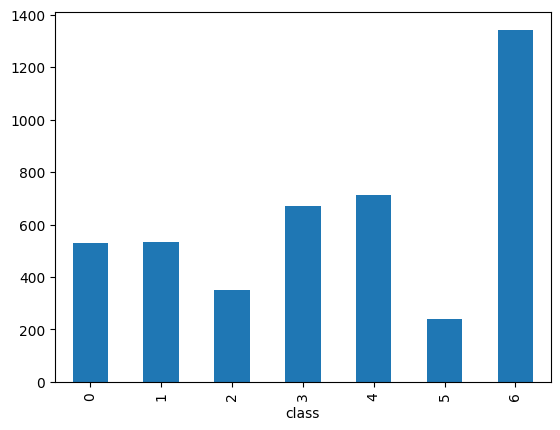

In [ ]:
human["class"].value_counts().sort_index().plot.bar()


<Axes: xlabel='class'>

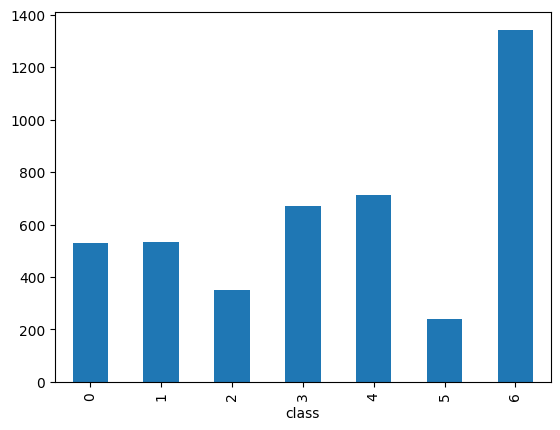

In [ ]:
human["class"].value_counts().sort_index().plot.bar()


<Axes: xlabel='class'>

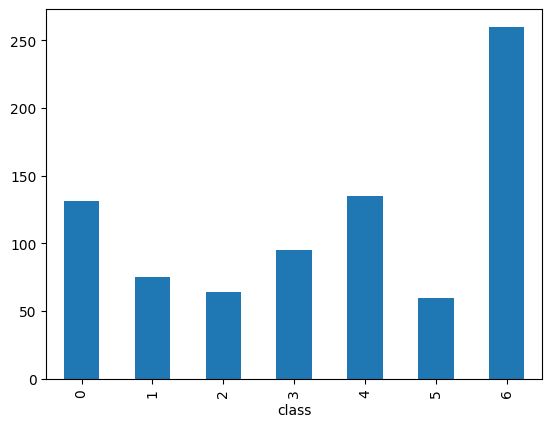

In [ ]:
dog["class"].value_counts().sort_index().plot.bar()


So now that we know how to transform our DNA sequences into uniform length numerical vectors in the form of k-mer counts and ngrams, we can now go ahead and build a classification model that can predict the DNA sequence function based only on the sequence itself.
Here I will use the human data to train the model, holding out 20% of the human data to test the model. Then we can really challenge the model's generalizability by trying to predict sequence function in other species (the chimpanzee and dog).
So below we will - 1: train/test spit. 2: Build simple multinomial naive Bayes classifier and 3: test the model performance.

## Only train using the human data

Generate the split

In [ ]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test=train_test_split(X,y_h,test_size=0.2,random_state=42)

In [ ]:
print(x_train.shape)
print(x_test.shape)

(3504, 232414)
(876, 232414)


Now let's make predictions on the human hold out test set and see how it performes on unseen data.

Okay, so let's look at some model performce metrics like the confusion matrix, accuracy, precision, recall and f1 score. We are getting really good results on our unseen data, so it looks like our model did not overfit to the training data. In a real project I would go back and sample many more train test splits since we have a relatively small data set.

In [ ]:
from yellowbrick.classifier import ConfusionMatrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def get_metrics(y_test, y_predicted):
    accuracy = accuracy_score(y_test, y_predicted)
    precision = precision_score(y_test, y_predicted, average='weighted')
    recall = recall_score(y_test, y_predicted, average='weighted')
    f1 = f1_score(y_test, y_predicted, average='weighted')
    return accuracy, precision, recall, f1

def train_evaluate_model(classifier, x_train, x_test, y_train, y_test):
    classifier.fit(x_train, y_train)
    y_pred = classifier.predict(x_test)

    # Using Yellowbrick's ConfusionMatrix visualizer
    visualizer = ConfusionMatrix(classifier, cmap='Blues', percent=True)
    visualizer.score(x_test, y_test)
    visualizer.show()

    accuracy, precision, recall, f1 = get_metrics(y_test, y_pred)
    print("accuracy = %.3f \nprecision = %.3f \nrecall = %.3f \nf1 = %.3f" % (accuracy, precision, recall, f1))

# Human Prediction

Multinomial Naive Bayes Classifier



/usr/local/lib/python3.10/dist-packages/yellowbrick/classifier/base.py:232: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  warnings.warn(


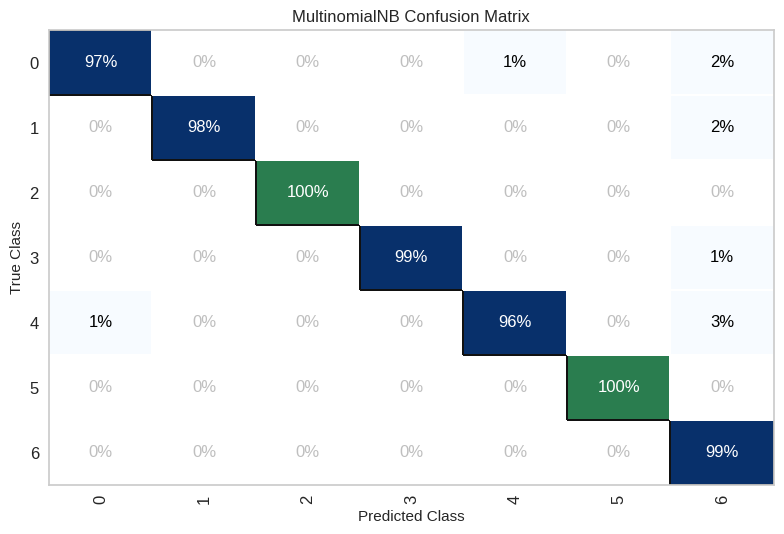

accuracy = 0.984 
precision = 0.984 
recall = 0.984 
f1 = 0.984
Random Forest Classifier



/usr/local/lib/python3.10/dist-packages/yellowbrick/classifier/base.py:232: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  warnings.warn(


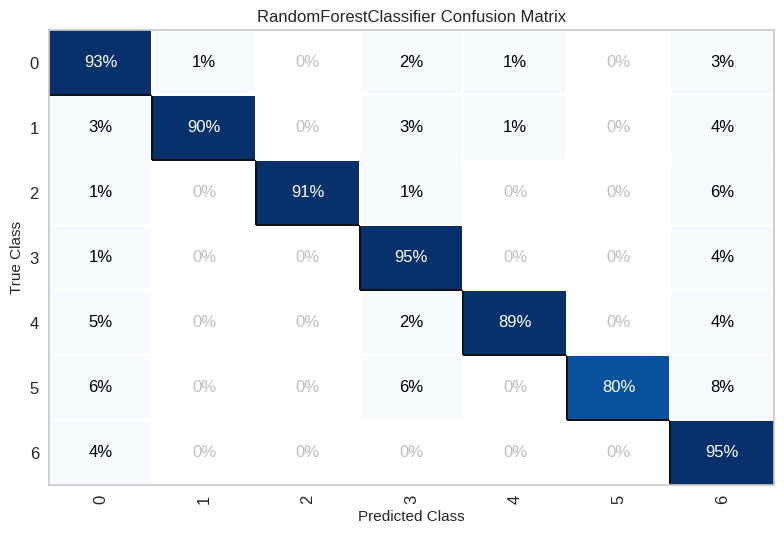

accuracy = 0.921 
precision = 0.928 
recall = 0.921 
f1 = 0.922
Support Vector Machine (SVM) Classifier



/usr/local/lib/python3.10/dist-packages/yellowbrick/classifier/base.py:232: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  warnings.warn(


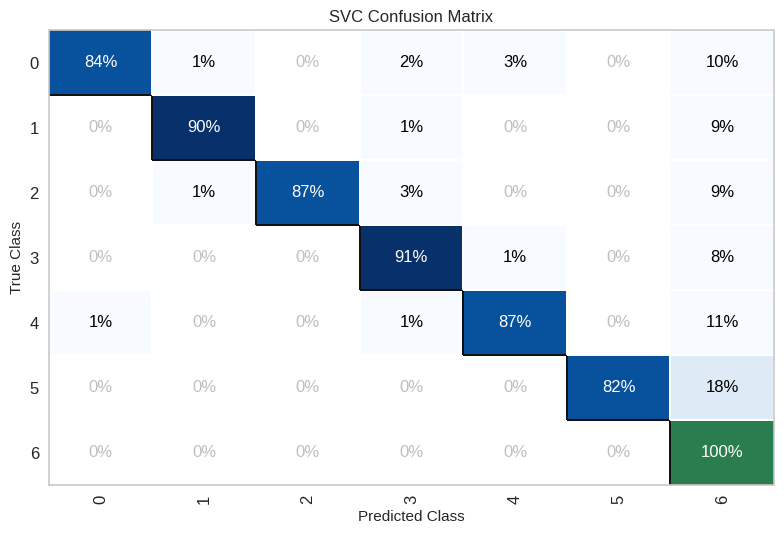

accuracy = 0.913 
precision = 0.926 
recall = 0.913 
f1 = 0.914
Gradient Boosting Classifier



/usr/local/lib/python3.10/dist-packages/yellowbrick/classifier/base.py:232: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  warnings.warn(


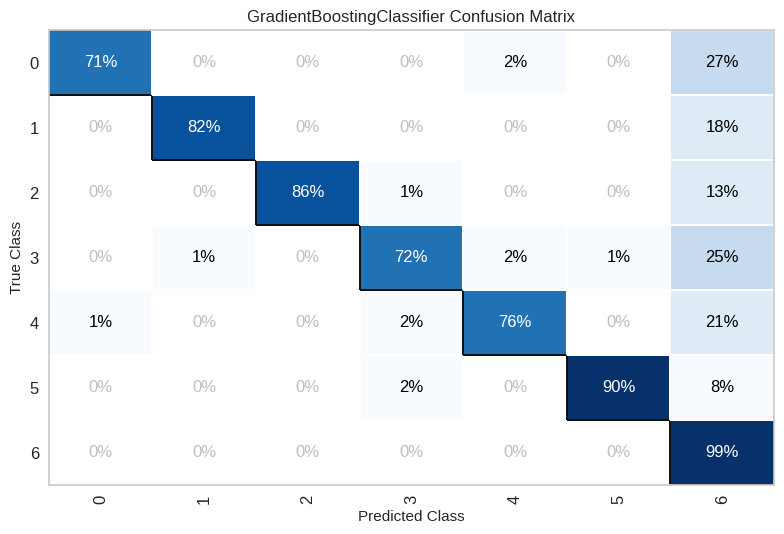

accuracy = 0.842 
precision = 0.883 
recall = 0.842 
f1 = 0.845


In [ ]:
# MultinomialNB Classifier
nb_classifier = MultinomialNB(alpha=0.1)
print("Multinomial Naive Bayes Classifier\n")
train_evaluate_model(nb_classifier, x_train, x_test, y_train, y_test)

# Random Forest Classifier
rf_classifier = RandomForestClassifier(random_state=42)
print("Random Forest Classifier\n")
train_evaluate_model(rf_classifier, x_train, x_test, y_train, y_test)

# Support Vector Machine (SVM) Classifier
svm_classifier = SVC(kernel='linear', random_state=42)
print("Support Vector Machine (SVM) Classifier\n")
train_evaluate_model(svm_classifier, x_train, x_test, y_train, y_test)

# Gradient Boosting Classifier
gb_classifier = GradientBoostingClassifier(random_state=42)
print("Gradient Boosting Classifier\n")
train_evaluate_model(gb_classifier, x_train, x_test, y_train, y_test)

# Chimp Prediction

Multinomial Naive Bayes Classifier



/usr/local/lib/python3.10/dist-packages/yellowbrick/classifier/base.py:232: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  warnings.warn(


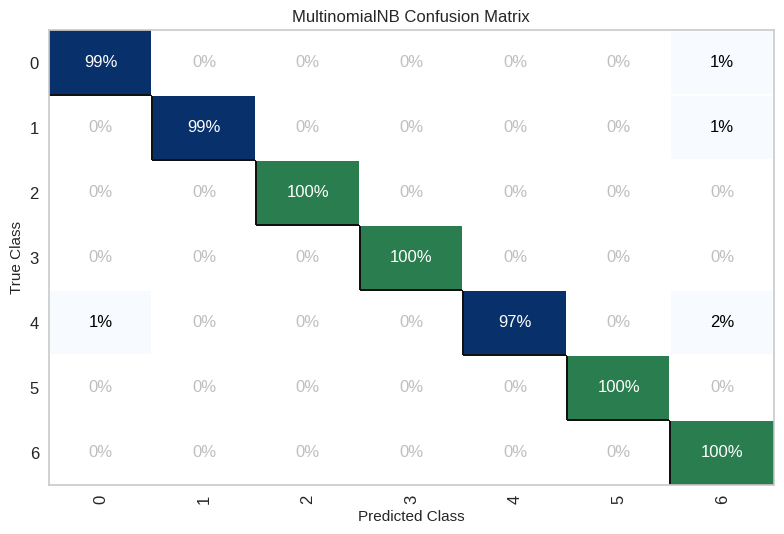

accuracy = 0.993 
precision = 0.994 
recall = 0.993 
f1 = 0.993
Random Forest Classifier



/usr/local/lib/python3.10/dist-packages/yellowbrick/classifier/base.py:232: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  warnings.warn(


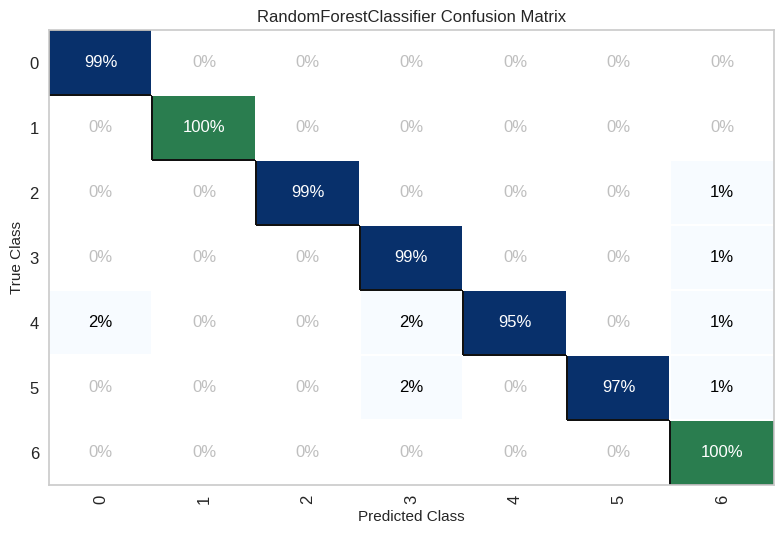

accuracy = 0.986 
precision = 0.987 
recall = 0.986 
f1 = 0.986
Support Vector Machine (SVM) Classifier



/usr/local/lib/python3.10/dist-packages/yellowbrick/classifier/base.py:232: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  warnings.warn(


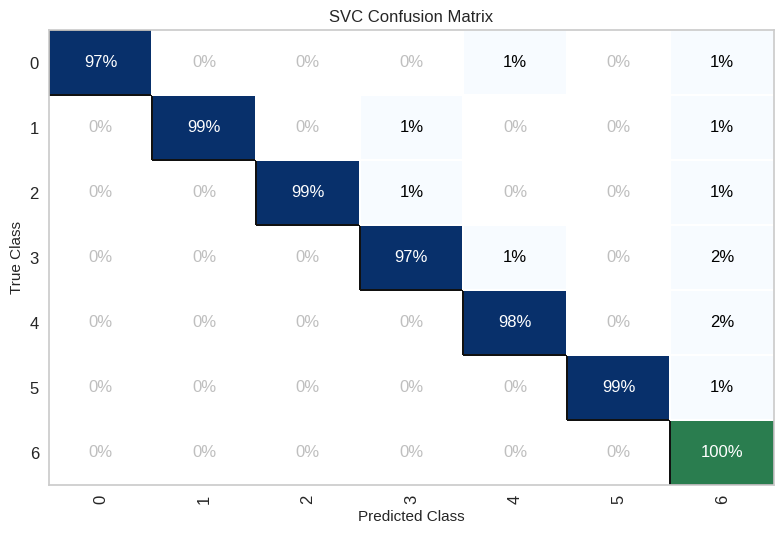

accuracy = 0.986 
precision = 0.986 
recall = 0.986 
f1 = 0.986
Gradient Boosting Classifier



/usr/local/lib/python3.10/dist-packages/yellowbrick/classifier/base.py:232: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  warnings.warn(


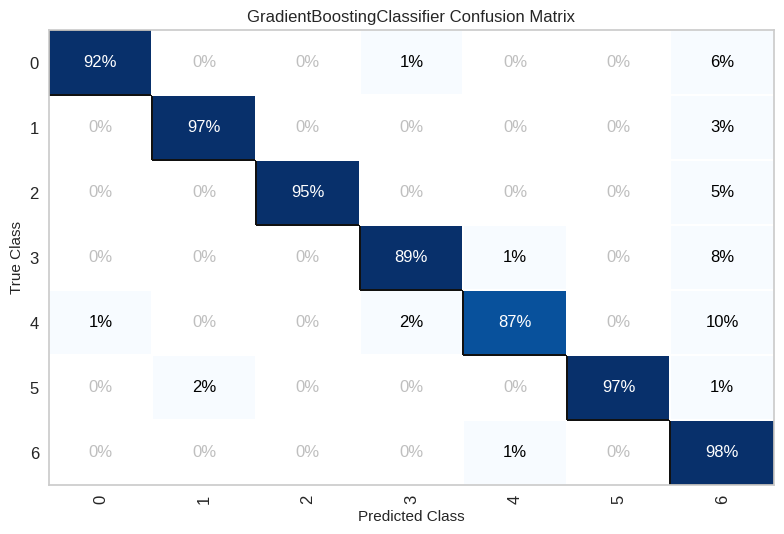

accuracy = 0.942 
precision = 0.945 
recall = 0.942 
f1 = 0.942


In [ ]:
# MultinomialNB Classifier
nb_classifier = MultinomialNB(alpha=0.1)
print("Multinomial Naive Bayes Classifier\n")
train_evaluate_model(nb_classifier, x_train, X_chimp, y_train, y_c)

# Random Forest Classifier
rf_classifier = RandomForestClassifier(random_state=42)
print("Random Forest Classifier\n")
train_evaluate_model(rf_classifier, x_train, X_chimp, y_train, y_c)

# Support Vector Machine (SVM) Classifier
svm_classifier = SVC(kernel='linear', random_state=42)
print("Support Vector Machine (SVM) Classifier\n")
train_evaluate_model(svm_classifier, x_train, X_chimp, y_train, y_c)

# Gradient Boosting Classifier
gb_classifier = GradientBoostingClassifier(random_state=42)
print("Gradient Boosting Classifier\n")
train_evaluate_model(gb_classifier, x_train, X_chimp, y_train, y_c)

# Dog Prediction

Multinomial Naive Bayes Classifier



/usr/local/lib/python3.10/dist-packages/yellowbrick/classifier/base.py:232: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  warnings.warn(


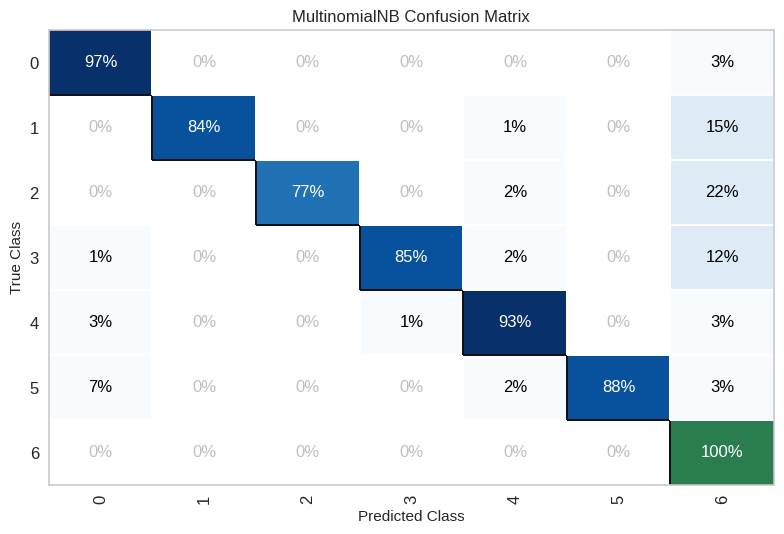

accuracy = 0.926 
precision = 0.934 
recall = 0.926 
f1 = 0.925
Random Forest Classifier



/usr/local/lib/python3.10/dist-packages/yellowbrick/classifier/base.py:232: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  warnings.warn(


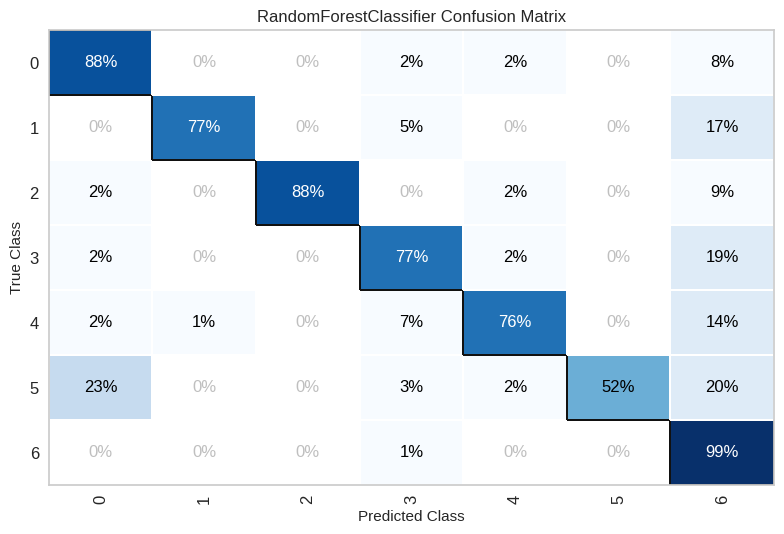

accuracy = 0.844 
precision = 0.863 
recall = 0.844 
f1 = 0.840
Support Vector Machine (SVM) Classifier



/usr/local/lib/python3.10/dist-packages/yellowbrick/classifier/base.py:232: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  warnings.warn(


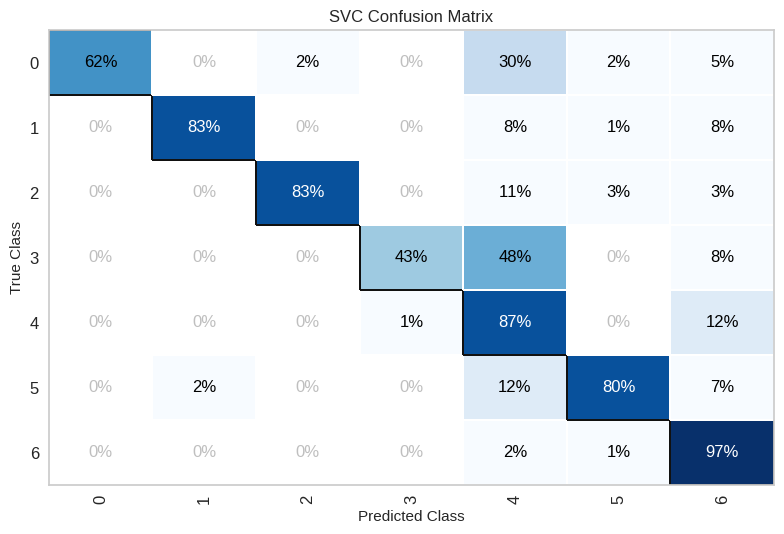

accuracy = 0.798 
precision = 0.855 
recall = 0.798 
f1 = 0.798
Gradient Boosting Classifier



/usr/local/lib/python3.10/dist-packages/yellowbrick/classifier/base.py:232: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  warnings.warn(


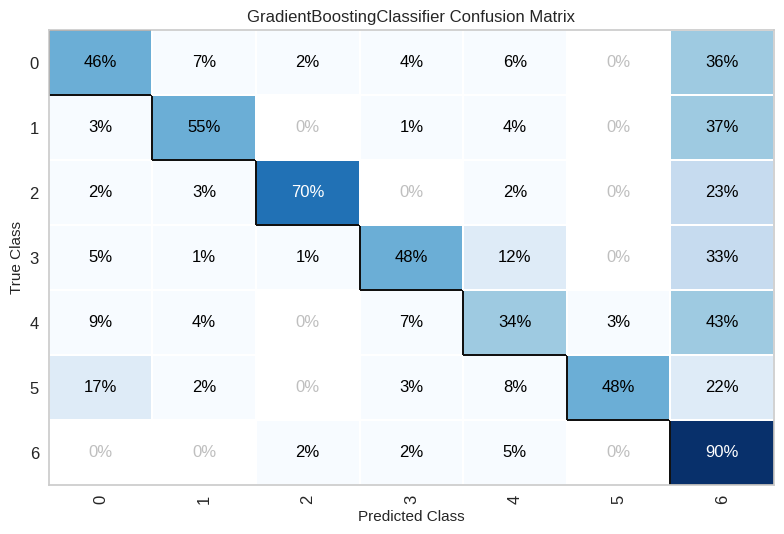

accuracy = 0.611 
precision = 0.636 
recall = 0.611 
f1 = 0.597


In [ ]:
# MultinomialNB Classifier
nb_classifier = MultinomialNB(alpha=0.1)
print("Multinomial Naive Bayes Classifier\n")
train_evaluate_model(nb_classifier, x_train, X_dog, y_train, y_d)

# Random Forest Classifier
rf_classifier = RandomForestClassifier(random_state=42)
print("Random Forest Classifier\n")
train_evaluate_model(rf_classifier, x_train, X_dog, y_train, y_d)

# Support Vector Machine (SVM) Classifier
svm_classifier = SVC(kernel='linear', random_state=42)
print("Support Vector Machine (SVM) Classifier\n")
train_evaluate_model(svm_classifier, x_train, X_dog, y_train, y_d)

# Gradient Boosting Classifier
gb_classifier = GradientBoostingClassifier(random_state=42)
print("Gradient Boosting Classifier\n")
train_evaluate_model(gb_classifier, x_train, X_dog, y_train, y_d)